<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/Med_Temp_Generate_New_Minimal_ML_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
% xmode verbose

Exception reporting mode: Verbose


In [3]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
#To remoount drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
# Load the Pandas libraries with alias 'pd' 
import sys
import os
import os.path
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt


import datetime as datetime
import math
import random




### Reading in the Test_Log of real data (**test_db_df**) and the record of fake data (**fake_test_db_df**)

In [5]:
base_descriptor = 'med_temp'

In [6]:
global fake_test_db_df
fake_test_db_df = pd.read_csv('/content/drive/My Drive/Fake_Test_Log_for_Minimal_ML_' + base_descriptor + '.csv')
for column in fake_test_db_df[['Acetone', 'CO2', 'Sensor', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'Total CO2', 'Sample_rate', 'New_Baseline']]:
     fake_test_db_df[column] = pd.to_numeric(fake_test_db_df[column])
fake_test_db_df.set_index('File', inplace = True)
fake_test_db_df.head()


,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9600,pdata9600,4% CO2 through plain water,10,40000,0.4,0.0000,NaN,0,1,19,2020-08-12,4:52:10,100000,1.0,40.21,NaN,26.97,26.70,4.29,NaN,NaN,250,29739,138.590360,140.299732,1.7094,-201.494212,2.564,641,9.720,2430,21.255789,15.180,3795,NaN,NaN,-964.480165,NaN,NaN,531.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9600
9603,pdata9603,4% CO2 through plain water,10,40000,0.8,0.0000,NaN,0,1,19,2020-08-12,5:02:22,612,2.0,41.68,NaN,26.38,26.17,4.38,NaN,NaN,250,29762,138.598053,139.051119,0.4531,-214.762738,2.588,647,9.784,2446,22.320042,15.192,3798,NaN,NaN,-1031.707572,NaN,NaN,553.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9603
9606,pdata9606,6% CO2 through plain water,10,60000,1.4,0.0000,NaN,0,1,19,2020-08-12,5:11:17,535,3.0,43.80,NaN,25.74,25.51,4.29,NaN,NaN,250,29775,138.543365,139.034170,0.4908,-319.336814,2.584,646,9.896,2474,32.715501,15.228,3807,NaN,NaN,-1551.996551,NaN,NaN,863.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9606
9609,pdata9609,6% CO2 through plain water,10,60000,2.0,0.0000,NaN,0,1,19,2020-08-12,5:20:20,543,4.0,43.88,NaN,25.39,25.10,4.24,NaN,NaN,250,29766,138.240113,138.832362,0.5922,-321.963345,2.616,654,9.956,2489,33.050086,15.388,3847,NaN,NaN,-1574.392437,NaN,NaN,854.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9609
9612,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10,40000,2.4,1.5625,NaN,0,1,19,2020-08-12,5:52:40,1940,5.0,40.49,NaN,26.04,25.87,4.27,NaN,NaN,250,29744,138.525839,138.691733,0.1659,-175.652029,2.588,647,9.692,2423,19.664613,15.152,3788,NaN,NaN,-843.821572,NaN,NaN,436.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9612


In [7]:
fake_test_db_df.head(-1)

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9600,pdata9600,4% CO2 through plain water,10,40000,0.4,0.0000,NaN,0,1,19,2020-08-12,4:52:10,100000,1.0,40.21,NaN,26.97,26.70,4.29,NaN,NaN,250,29739,138.590360,140.299732,1.7094,-201.494212,2.564,641,9.720,2430,21.255789,15.180,3795,NaN,NaN,-964.480165,NaN,NaN,531.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9600
9603,pdata9603,4% CO2 through plain water,10,40000,0.8,0.0000,NaN,0,1,19,2020-08-12,5:02:22,612,2.0,41.68,NaN,26.38,26.17,4.38,NaN,NaN,250,29762,138.598053,139.051119,0.4531,-214.762738,2.588,647,9.784,2446,22.320042,15.192,3798,NaN,NaN,-1031.707572,NaN,NaN,553.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9603
9606,pdata9606,6% CO2 through plain water,10,60000,1.4,0.0000,NaN,0,1,19,2020-08-12,5:11:17,535,3.0,43.80,NaN,25.74,25.51,4.29,NaN,NaN,250,29775,138.543365,139.034170,0.4908,-319.336814,2.584,646,9.896,2474,32.715501,15.228,3807,NaN,NaN,-1551.996551,NaN,NaN,863.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9606
9609,pdata9609,6% CO2 through plain water,10,60000,2.0,0.0000,NaN,0,1,19,2020-08-12,5:20:20,543,4.0,43.88,NaN,25.39,25.10,4.24,NaN,NaN,250,29766,138.240113,138.832362,0.5922,-321.963345,2.616,654,9.956,2489,33.050086,15.388,3847,NaN,NaN,-1574.392437,NaN,NaN,854.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9609
9612,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10,40000,2.4,1.5625,NaN,0,1,19,2020-08-12,5:52:40,1940,5.0,40.49,NaN,26.04,25.87,4.27,NaN,NaN,250,29744,138.525839,138.691733,0.1659,-175.652029,2.588,647,9.692,2423,19.664613,15.152,3788,NaN,NaN,-843.821572,NaN,NaN,436.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,pdata9960,Combo of 9840 and 9846 | Weight - 0.5,10,50000,9.9,18.7500,NaN,0,1,19,2020-08-12,NaN,967,20.0,NaN,NaN,26.27,NaN,NaN,NaN,NaN,250,29718,138.666745,NaN,NaN,-233.562661,2.572,643,8.540,2135,46.532383,14.256,3564,NaN,NaN,-1051.000000,NaN,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9960
9963,pdata9963,Combo of 9843 and 9849 | Weight - 0.5,10,50000,10.4,18.7500,NaN,0,1,19,2020-08-12,NaN,534,21.0,NaN,NaN,26.26,NaN,NaN,NaN,NaN,250,297

In [8]:
print(len(fake_test_db_df))

126


In [9]:
def make_new_fake_real_metadata(signal,num):

    fake_test_db_df.loc[num, 'Data_pts'] = len(signal)
    sample_rate = 250
    peak_pos = signal['mV_rolling_mean'].max()
    peak_pos_t_ix = signal['mV_rolling_mean'].idxmax()
    peak_pos_t = signal.loc[peak_pos_t_ix,'Second']
    fake_test_db_df.loc[num, 'Peak_pos'] = peak_pos
    fake_test_db_df.loc[num, 'Peak_pos_t'] = peak_pos_t
    fake_test_db_df.loc[num, 'Peak_pos_t_ix'] = peak_pos_t_ix
    peak_neg = signal['mV_rolling_mean'].min()
    peak_neg_t_ix = signal['mV_rolling_mean'].idxmin()
    peak_neg_t = signal.loc[peak_neg_t_ix,'Second']
    fake_test_db_df.loc[num, 'Peak_neg'] = peak_neg
    fake_test_db_df.loc[num, 'Peak_neg_t'] = peak_neg_t
    fake_test_db_df.loc[num, 'Peak_neg_t_ix'] = peak_neg_t_ix
    
    pos_data = signal.truncate(before=peak_neg_t_ix, axis=None)
# find x-point --- first trim all negative data
    cross_t_ix = (pos_data['mV_rolling_mean'] >= 0).idxmax()
# get time at x-point
    cross_t = pos_data.loc[cross_t_ix,'Second']
    
    fake_test_db_df.loc[num, 'Cross_t'] = cross_t
    fake_test_db_df.loc[num, 'Cross_t_ix'] = cross_t_ix
        
# get positive area
    pos_data = signal.truncate(before = cross_t_ix)
    pk_8th = peak_pos/8
    pk_16th = peak_pos/16
    tail_data = signal.truncate(before=peak_pos_t_ix)
    last_pt = pos_data['mV_rolling_mean'].values[-1]
    if last_pt < pk_16th:
        pk_16th_t_ix = (tail_data['mV_rolling_mean'] <= pk_16th).idxmax()
        pos_data_16 = pos_data.truncate(after = pk_16th_t_ix)
        area_pos_16 = int(pos_data_16['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_16'] = int(area_pos_16/sample_rate)
#Exclude these calculations for short tests
    if last_pt < pk_8th:
        pk_8th_t_ix = (tail_data['mV_rolling_mean'] <= pk_8th).idxmax()
        pos_data_8 = pos_data.truncate(after = pk_8th_t_ix)
        area_pos_8 = int(pos_data_8['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_8'] = int(area_pos_8/sample_rate)
        area_pos = int(area_pos_8/sample_rate)*1.27-173
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
    else:
        area_pos = 0
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
# get Negative area      
    neg_data = signal.truncate(after = cross_t_ix)
    area_neg = int(neg_data['mV_rolling_mean'].sum()) 
    fake_test_db_df.loc[num, 'Area_neg'] = int(area_neg/sample_rate)
# post total area
    fake_test_db_df.loc[num, 'Area_total'] = area_neg + area_pos
    return fake_test_db_df
    #fake_test_db_df.to_csv('/content/drive/My Drive/Fake_Test_Log_for_Minimal_ML.csv', index = False)


In [10]:
### VALUES FOR SENSOR 19
### VALUES FOR SENSOR 19
mll = (9600,9603)
mlh = (9606,9609)
mml = (9648,9651)
mmh = (9654,9657)
mhl = (9660,9663)
mhh = (9666,9669)
lll = (9672,9675)
llh = (9678,9681)
lml = (9720,9723)
lmh = (9726,9729)
lhl = (9732,9735)
lhh = (9738,9741)
hll = (9744,9747)
hlh = (9750,9753)
hml = (9792,9795)
hmh = (9798,9801)
hhl = (9804,9807)
hhh = (9810,9813)

In [11]:
###Assumes that tests have the same sample rate
def make_a_fake_test_string(test1, test2, filenum, howmany,fake_test_db_df):
    print(test1, test2, filenum)
    new_tests = [test1]
    root_path_1a = '/content/drive/My Drive/Minimal_Fakes_19_' + base_descriptor + '/test_output' + str(test1) + '.csv'
    root_path_1b ='/content/drive/My Drive/Test_outputs/General/test_output' + str(test1) + '.csv'
    root_path_2a = '/content/drive/My Drive/Minimal_Fakes_19_' + base_descriptor + '/test_output' + str(test2) + '.csv'
    root_path_2b ='/content/drive/My Drive/Test_outputs/General/test_output' + str(test2) + '.csv'
  
    if os.path.exists(root_path_1a):
      signal1 = pd.read_csv(root_path_1a)
    else:
      signal1 = pd.read_csv(root_path_1b)

    if os.path.exists(root_path_2a):
      signal2 = pd.read_csv(root_path_2a)
    else:
      signal2 = pd.read_csv(root_path_2b)

    len1 = len(signal1.index)
    len2 = len(signal2.index)
    if len1 > len2:
        signal1 = signal1.truncate(after=len2)
    else:
        signal2 = signal2.truncate(after=len1)
    fake_signal = signal2.copy()
    interval = 1/(howmany + 1)
    for i in range(howmany):
        weight = interval * (i+1)
        fake_signal['mV_rolling_mean'] = signal1['mV_rolling_mean']+((signal2['mV_rolling_mean']-signal1['mV_rolling_mean'])*weight)
        fake_signal.to_csv('/content/drive/My Drive/Minimal_Fakes_19_' + base_descriptor + '/test_output' + str(filenum) + '.csv', index=False, columns=['Second', 'mV_rolling_mean'])
        fake_test_db_df = write_fake_real_metadata(test1, test2, weight, filenum, fake_test_db_df)
        fake_test_db_df = make_new_fake_real_metadata(fake_signal,filenum)
        new_tests.append(filenum)
        filenum = filenum + 1
    fake_test_db_df.to_csv('/content/drive/My Drive/Fake_Test_Log_for_Minimal_ML_' + base_descriptor + '.csv')
    new_tests.append(test2)
    return(new_tests,filenum)
    

In [12]:
def write_fake_real_metadata(test1, test2, weight, num, fake_test_db_df):

    param_list = ['CO2', 'Total CO2', 'Acetone', 'Time_Btwn_s', 'Test_that_day', 'Instr_Temp', 'Baseline', 'New_Baseline']
    for param in param_list:
        fake_test_db_df[param] = pd.to_numeric(fake_test_db_df[param])
    fake_test_db_df.loc[num, 'File_num'] = num
    fake_test_db_df.loc[num, 'Instr'] = fake_test_db_df.loc[test1, 'Instr']
    fake_test_db_df.loc[num, 'Sensor'] = fake_test_db_df.loc[test1, 'Sensor']
    fake_test_db_df.loc[num, 'Sample_rate'] = 250
    fake_test_db_df.loc[num, 'H2O'] = fake_test_db_df.loc[test1, 'H2O']

    fake_test_db_df.loc[num, 'Test_name'] = 'Combo of ' + str(test1) + ' and ' + str(test2) + ' | Weight - ' + str(weight)
    fake_test_db_df.loc[num, 'CO2'] = (fake_test_db_df.loc[test1, 'CO2']) + (((fake_test_db_df.loc[test2, 'CO2']) - (fake_test_db_df.loc[test1, 'CO2']))*weight)
    fake_test_db_df.loc[num, 'Total CO2'] = (fake_test_db_df.loc[test1, 'Total CO2']) + (((fake_test_db_df.loc[test2, 'Total CO2']) - (fake_test_db_df.loc[test1, 'Total CO2']))*weight)
    fake_test_db_df.loc[num, 'Acetone'] = (fake_test_db_df.loc[test1, 'Acetone']) + (((fake_test_db_df.loc[test2, 'Acetone']) - (fake_test_db_df.loc[test1, 'Acetone']))*weight)
    fake_test_db_df.loc[num, 'Time_Btwn_s'] = (fake_test_db_df.loc[test1, 'Time_Btwn_s']) + (((fake_test_db_df.loc[test2, 'Time_Btwn_s']) - (fake_test_db_df.loc[test1, 'Time_Btwn_s']))*weight)
    fake_test_db_df.loc[num, 'Test_that_day'] = (fake_test_db_df.loc[test1, 'Test_that_day']) + (((fake_test_db_df.loc[test2, 'Test_that_day']) - (fake_test_db_df.loc[test1, 'Test_that_day']))*weight)
    fake_test_db_df.loc[num, 'Instr_Temp'] = (fake_test_db_df.loc[test1, 'Instr_Temp']) + (((fake_test_db_df.loc[test2, 'Instr_Temp']) - (fake_test_db_df.loc[test1, 'Instr_Temp']))*weight)
    fake_test_db_df.loc[num, 'Baseline'] = (fake_test_db_df.loc[test1, 'Baseline']) + (((fake_test_db_df.loc[test2, 'Baseline']) - (fake_test_db_df.loc[test1, 'Baseline']))*weight)
    fake_test_db_df.loc[num, 'New_Baseline'] = (fake_test_db_df.loc[test1, 'New_Baseline']) + (((fake_test_db_df.loc[test2, 'New_Baseline']) - (fake_test_db_df.loc[test1, 'New_Baseline']))*weight)
    
    return fake_test_db_df
    #fake_test_db_df.to_csv('/content/drive/My Drive/Fake_Test_Log_for_Minimal_ML.csv', index = False)

In [16]:
### WITH MEDIUM TEMPERATURE REAL DATA
### fill should be an even number
fill = 28
start_file_num = 10000

ll,next_num = make_a_fake_test_string(random.choice(lll), random.choice(llh), start_file_num, fill, fake_test_db_df)
#print(ll)
lh,next_num = make_a_fake_test_string(random.choice(lhl), random.choice(lhh), next_num, fill, fake_test_db_df)
#print(lh)
ml,next_num = make_a_fake_test_string(random.choice(mll), random.choice(mlh), next_num, fill, fake_test_db_df)
#print(ml)
mh,next_num = make_a_fake_test_string(random.choice(mhl), random.choice(mhh), next_num, fill,fake_test_db_df)
#print(mh)
hl,next_num = make_a_fake_test_string(random.choice(hll), random.choice(hlh), next_num, fill,fake_test_db_df)
#print(hl)
hh,next_num = make_a_fake_test_string(random.choice(hhl), random.choice(hhh), next_num, fill, fake_test_db_df)
#print(hh)

for i in range(len(ll)):
    l,next_num = make_a_fake_test_string(ll[i],lh[i],next_num,fill, fake_test_db_df)
    m,next_num = make_a_fake_test_string(ml[i],mh[i],next_num,fill, fake_test_db_df)
    h,next_num = make_a_fake_test_string(hl[i],hh[i],next_num,fill, fake_test_db_df)
    print(l)
    print(m)
    print(h)
    for j in range(len(l)):
            l_m,next_num = make_a_fake_test_string(l[j],m[j],next_num,int(fill/2), fake_test_db_df)
            m_h,next_num = make_a_fake_test_string(m[j],h[j],next_num,int(fill/2), fake_test_db_df)


9675 9681 10000
9735 9738 10028
9603 9606 10056
9663 9669 10084
9744 9753 10112
9807 9810 10140
9675 9735 10168
9603 9663 10196
9744 9807 10224
[9675, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 9735]
[9603, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223, 9663]
[9744, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 9807]
9675 9603 10252
9603 9744 10266
10168 10196 10280
10196 10224 10294
10169 10197 10308
10197 10225 10322
10170 10198 10336
10198 10226 10350
10171 10199 10364
10199 10227 10378
10172 10200 10392
10200 10228 10406
10173 10201 10420

In [17]:
print(len(fake_test_db_df))

28014


In [18]:
fake_test_db_df.to_csv('/content/drive/My Drive/Fake_Test_Log_for_Minimal_ML_' + base_descriptor + '.csv')

### Check density of generated tests


In [19]:

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [21]:
def make_db_from_get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    new_df = filtered.loc[filtered.index > Range1]
    new_df = new_df.loc[new_df.index < Range2]
    return(filtered)

28014


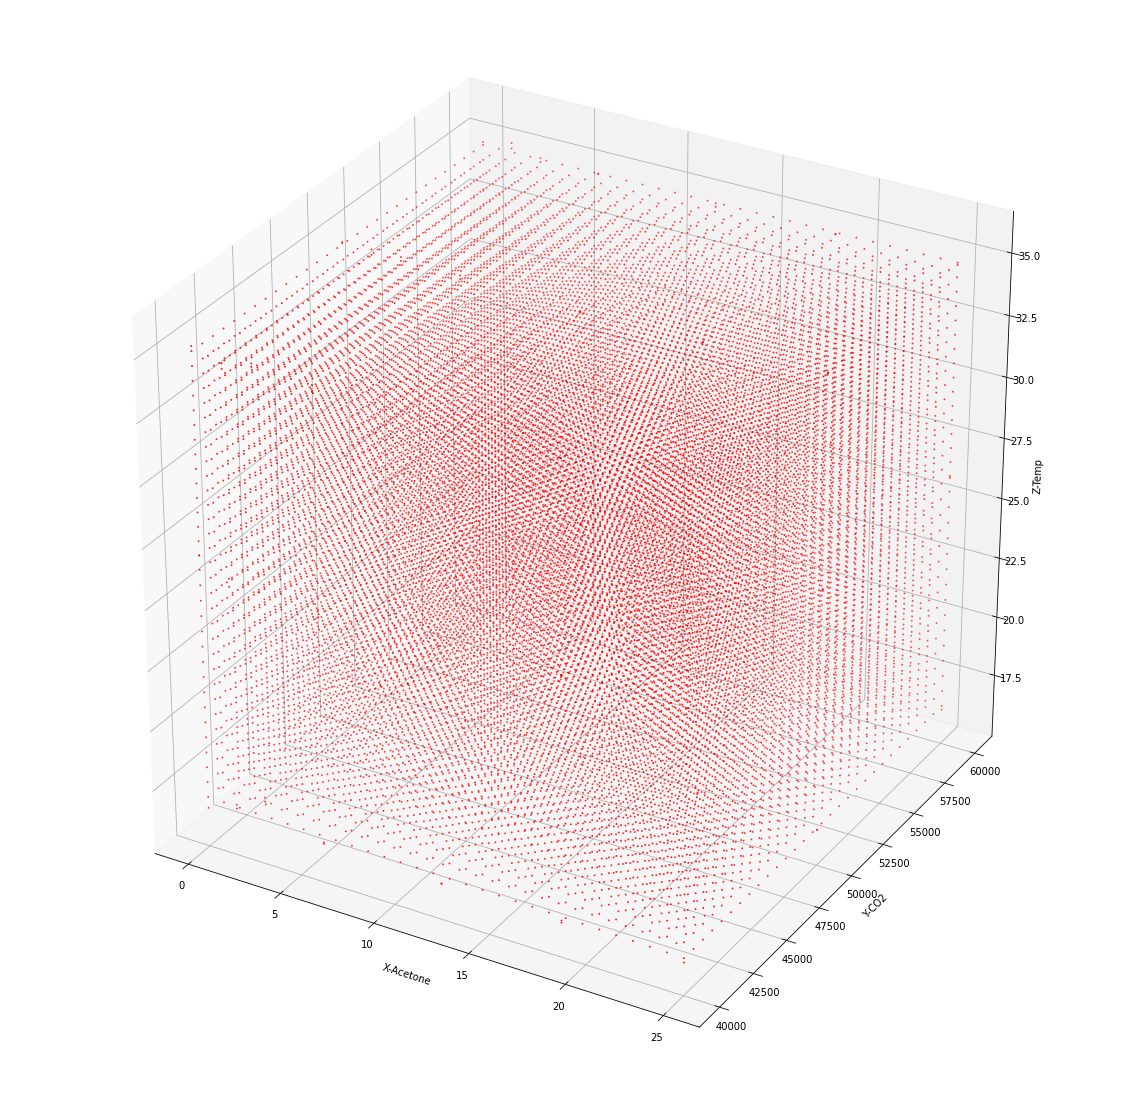

In [22]:
db = make_db_from_get_test_list (fake_test_db_df, 'all', '+', 10, 19, 10000, 900000)
print(len(db))
#plot points and fitted surface
X= db['Acetone']
Y =db['CO2']
Z =db['Instr_Temp']

# plot points and fitted surface
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(X, Y, Z, c='r', s=1)
plt.xlabel('X-Acetone')
plt.ylabel('Y-CO2')
ax.set_zlabel('Z-Temp')
ax.axis('tight')
plt.show()

In [ ]:
print(len(db))

32886


In [ ]:
db.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests
1545,pdata9600,4% CO2 through plain water,10.0,40000.0,0.4,0.0000,NaN,0.0,1.0,19.0,2020-08-12,4:52:10,100000.0,1.0,40.21,NaN,26.97,26.70,4.29,NaN,NaN,250.0,29739.0,138.590360,NaN,NaN,-201.494212,2.564,641.0,9.720,2430.0,21.255789,15.180,3795.0,NaN,NaN,-964.480165,NaN,NaN,531.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1545
1548,pdata9603,4% CO2 through plain water,10.0,40000.0,0.8,0.0000,NaN,0.0,1.0,19.0,2020-08-12,5:02:22,612.0,2.0,41.68,NaN,26.38,26.17,4.38,NaN,NaN,250.0,29762.0,138.598053,NaN,NaN,-214.762738,2.588,647.0,9.784,2446.0,22.320042,15.192,3798.0,NaN,NaN,-1031.707572,NaN,NaN,553.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1548
1551,pdata9606,6% CO2 through plain water,10.0,60000.0,1.4,0.0000,NaN,0.0,1.0,19.0,2020-08-12,5:11:17,535.0,3.0,43.80,NaN,25.74,25.51,4.29,NaN,NaN,250.0,29775.0,138.543365,NaN,NaN,-319.336814,2.584,646.0,9.896,2474.0,32.715501,15.228,3807.0,NaN,NaN,-1551.996551,NaN,NaN,863.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1551
1554,pdata9609,6% CO2 through plain water,10.0,60000.0,2.0,0.0000,NaN,0.0,1.0,19.0,2020-08-12,5:20:20,543.0,4.0,43.88,NaN,25.39,25.10,4.24,NaN,NaN,250.0,29766.0,138.240113,NaN,NaN,-321.963345,2.616,654.0,9.956,2489.0,33.050086,15.388,3847.0,NaN,NaN,-1574.392437,NaN,NaN,854.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1554
1557,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10.0,40000.0,2.4,1.5625,NaN,0.0,1.0,19.0,2020-08-12,5:52:40,1940.0,5.0,40.49,NaN,26.04,25.87,4.27,NaN,NaN,250.0,29744.0,138.525839,NaN,NaN,-175.652029,2.588,647.0,9.692,2423.0,19.664613,15.152,3788.0,NaN,NaN,-843.821572,NaN,NaN,436.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1557


## Remove tests from fake test log

In [ ]:
print(len(fake_test_db_df))

228787


In [ ]:
def remove_from_df (df, Sensor):


    filtered = df[(df['Sensor'] != Sensor)]

    return filtered

In [ ]:
fake_test_db_df = remove_from_df(fake_test_db_df, 10)
print(len(fake_test_db_df))

191731


In [ ]:
 fake_test_db_df.to_csv('/content/drive/My Drive/Original_Fake_Test_Log.csv', index = False)

#Troubleshooting

In [ ]:
fake_test_db_df.set_index('File', inplace = True)

        Second  mV_rolling_mean
0        0.000        -0.508049
1        0.004        -0.508867
2        0.008        -0.513536
3        0.012        -0.516570
4        0.016        -0.516570
...        ...              ...
30121  120.484         7.031810
30122  120.488         7.030584
30123  120.492         7.030584
30124  120.496         7.026322
30125  120.500         7.021653

[30126 rows x 2 columns]
        Second  mV_rolling_mean
0        0.000        -0.314652
1        0.004        -0.314652
2        0.008        -0.314652
3        0.012        -0.313232
4        0.016        -0.308971
...        ...              ...
27452  109.808         6.468440
27453  109.812         6.468440
27454  109.816         6.468440
27455  109.820         6.468440
27456  109.824         6.468440

[27457 rows x 2 columns]
cross t for red one 8.712000000000005
cross t for blue one8.116000000000003
peak pos for red one 103.39837754638815
peak pos for blue one 90.66549020398749
peak pos time for red on

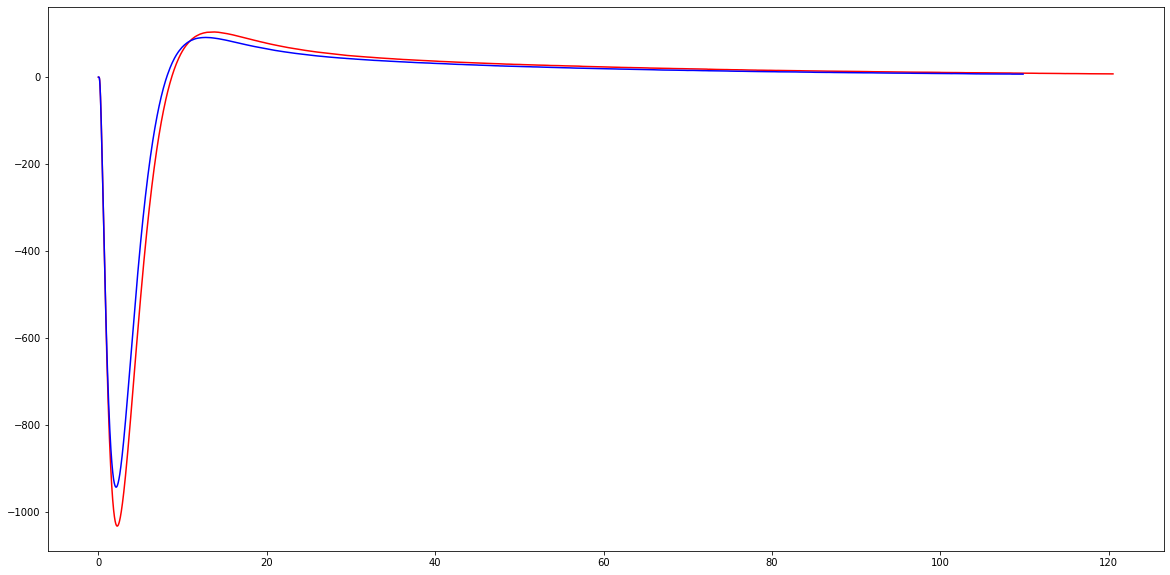

In [ ]:
bad_data = pd.read_csv('/content/drive/My Drive/Fakes_09/test_output62172.csv')
bad_data3 = pd.read_csv('/content/drive/My Drive/Fakes_09/test_output62173.csv')
bad_data2 = pd.read_csv('/content/drive/My Drive/Fakes_09/test_output10006.csv')
print(bad_data)
print(bad_data2)

xtime1 = fake_test_db_df.loc[62172, 'Cross_t']
xtime2 = fake_test_db_df.loc[10006, 'Cross_t']

pp1 = fake_test_db_df.loc[62172, 'Peak_pos']
pp2 = fake_test_db_df.loc[10006, 'Peak_pos']

pp1t = fake_test_db_df.loc[62172, 'Peak_pos_t']
pp2t = fake_test_db_df.loc[10006, 'Peak_pos_t']

pn1 = fake_test_db_df.loc[62172, 'Peak_neg']
pn2 = fake_test_db_df.loc[10006, 'Peak_neg']

plt.figure(figsize = [20,10])
plt.plot(bad_data['Second'], bad_data['mV_rolling_mean'], c= 'r')
plt.plot(bad_data2['Second'], bad_data2['mV_rolling_mean'], c= 'b')

print('cross t for red one ' + str(xtime1))
print('cross t for blue one' + str(xtime2))

print('peak pos for red one ' + str(pp1))
print('peak pos for blue one ' + str(pp2))

print('peak pos time for red one ' + str(pp1t))
print('peak pos time for blue one ' + str(pp2t))

print('peak neg for red one ' + str(pn1))
print('peak neg for blue one ' + str(pn2))

In [ ]:
fake_test_db_df.head()

,File,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
0,200000.0,NaN,Combo of 5134 and 5262 | Weight - 0.79,10.0,42100.0,58.98,9.2125,NaN,NaN,38263.0,14.0,NaN,NaN,603.85,19.16,NaN,NaN,26.5967,NaN,NaN,NaN,NaN,250.0,55701.0,26.907357,27.085221,NaN,-395.676821,2.356,589.0,9.056,2264.0,45.245946,14.248,3562.0,NaN,NaN,-1770.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200001.0,NaN,Combo of 5134 and 5262 | Weight - 0.67,10.0,43300.0,55.14,8.7625,NaN,NaN,38263.0,14.0,NaN,NaN,602.05,18.68,NaN,NaN,27.9491,NaN,NaN,NaN,NaN,250.0,55701.0,27.999765,28.284850,NaN,-427.395069,2.332,583.0,8.900,2225.0,48.576854,14.248,3562.0,NaN,NaN,-1876.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200002.0,NaN,Combo of 5134 and 5262 | Weight - 0.94,10.0,40600.0,63.78,9.7750,NaN,NaN,38263.0,14.0,NaN,NaN,606.10,19.76,NaN,NaN,24.9062,NaN,NaN,NaN,NaN,250.0,55701.0,25.541849,25.585685,NaN,-356.231984,2.408,602.0,9.276,2319.0,41.082312,14.248,3562.0,NaN,NaN,-1638.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200003.0,NaN,Combo of 5134 and 5262 | Weight - 0.52,10.0,44800.0,50.34,8.2000,NaN,NaN,38263.0,14.0,NaN,NaN,599.80,18.08,NaN,NaN,29.6396,NaN,NaN,NaN,NaN,250.0,55701.0,29.365274,29.784387,NaN,-467.191336,2.288,572.0,8.728,2182.0,52.825978,13.876,3469.0,NaN,NaN,-2010.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200004.0,NaN,Combo of 5134 and 5262 | Weight - 0.52,10.0,44800.0,50.34,8.2000,NaN,NaN,38263.0,14.0,NaN,NaN,599.80,18.08,NaN,NaN,29.6396,NaN,NaN,NaN,NaN,250.0,55701.0,29.365274,29.784387,NaN,-467.191336,2.288,572.0,8.728,2182.0,52.825978,13.876,3469.0,NaN,NaN,-2010.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
peak_neg = bad_data['mV_rolling_mean'].min()
print(peak_neg)

peak_neg3 = bad_data3['mV_rolling_mean'].min()
print(peak_neg3)

-1031.3685903029034
-1103.298910574404


In [ ]:
test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,wav3000,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,13:53:44,50024,1.0,,,0.0,,,,,250,8076,26.770204,25.93022,-0.8400,-2.495264403,18.42,1842,,,34.06133447,1.32,132,,-1060,,,,2.67,...,,,0.13728,-0.73976,,,,,,,,,,,,,,,,,,,,0.6115311406,0.3,30,-0.1127246342,2.58,258,6.98,698,0.03976674596,0.21,21,-0.01064621545,0.45,45,1.88,188,
3001,wav3000,Nitrogen blank,0,0,0.0,0.0,,0,38263,6,2020-02-11,13:54:02,50042,1.0,,,0.0,,,,,250,6253,25.223295,25.26792,0.0446,-3.68E+00,10.28,1028,,,45.33028225,1.14,114,,1737,,,,18.17,...,,,0.07312,-0.62940,,,,,,,,,,,,,,,,,,,,0.9091349749,0.29,29,-0.145461596,2.57,257,8.25,825,0.06433878284,0.21,21,-0.01647321493,0.49,49,1.8,180,
3002,wav3001,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,13:56:27,163,2.0,,,0.0,,,,,250,5380,26.311880,26.37235,0.0605,-2.476566964,18.05,1805,,,38.78064916,1.27,127,,5373,,,,62.95,...,,,0.01004,-0.67635,,,,,,,,,,,,,,,,,,,,0.721437659,0.29,29,-0.1183608659,2.76,276,7.92,792,0.05009983743,0.22,22,-0.01189871139,0.48,48,1.76,176,
3003,wav3001,Nitrogen blank,0,0,0.0,0.0,,0,38263,6,2020-02-11,13:56:36,154,2.0,,,0.0,,,,,250,4455,25.250096,25.23670,-0.0134,-3.71E+00,11.82,1182,,,45.63916201,1.15,115,,5217,,,,51.52,...,,,0,-0.31470,,,,,,,,,,,,,,,,,,,,0.9063376365,0.3,30,-0.1398669192,2.44,244,8.37,837,0.06278470596,0.22,22,-0.01491913805,0.52,52,1.72,172,
3004,wav3002,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,14:04:19,472,3.0,,,0.0,,,,,250,4184,26.724979,26.90321,0.1782,-2.078048257,18.13,1813,,,32.95676806,1.29,129,,6489,,,,72.46,...,,,0.0067,-0.67635,,,,,,,,,,,,,,,,,,,,0.6058949089,0.3,30,-0.1042702866,2.47,247,7.64,764,0.04383735775,0.22,22,-0.009393719518,0.48,48,1.75,175,
